# Documentation: Merging WSDOT and SDOT Data

This notebook documents the process of merging the traffic collision data from the Seattle Dept. of Transportation (SDOT) with the Wash. State Dept. of Transportation (WSDOT).  

Initially, I used an inner join, but given the work everyone has already done on the SDOT data, I decided to keep all the SDOT data in the merged data set.  


#### WSDOT data
On 8/6/20, I received a CSV file in response to my earlier public records request for King County data: 579,792 total rows; 212,396 with City listed as Seattle; 255 columns   

Data spans 2005-2020: I requested data from 2004 to the present, but was told the data is only available beginning in 2005.  

When I initially read the CSV file from WSDOT, I got this Unicode error:  
`UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa7 in position 19: invalid start byte`  
so I used `encoding = "ISO-8859-1"` to read file  

Columns that begin with TZ refer to Target Zero, and [Appendix E](http://targetzero.com/wp-content/uploads/2020/03/TargetZero2019_Appendices_Lo-Res.pdf) describes all the TZ variables.  

In 2000, Wash. State set the Target Zero goal: zero deaths and serious injuries by 2030. In measuring progress, the WSDOT uses (1) Rates based on vehicle miles traveled (VMT), (2) Rates based on population (aka 100,000 people), and (3) Rates based on licensed or endorsed drivers.  

The Collision Location and Analysis System (CLAS), a crash data repository, is the source of Target Zero’s serious injury data. CLAS is housed at the WSDOT and most of the data comes from law enforcement officers via the Police Traffic Collision Report (PTCR). Citizens may also submit non-police assisted reports of crash events via the Citizen Vehicle Collision Report.  

CLAS stores all reportable traffic crash data for Washington State public roadways. A crash needs to meet at least one of the two following criteria to be considered reportable: 1) a minimum property damage
threshold of \$1,000, and/or 2) bodily injury occurred as a result of the crash. See [targetzero.com](https://targetzero.com) for information.   


#### SDOT data
I downloaded the publicly available CSV file on 8/7/20 (220,650 rows & 40 columns) and the data spans the years 2004-2020   


#### Other Data 
May want to request Department of Licensing Driver Record Data. The Washington State Department of Licensing (DOL) provides the driver record data used in Target Zero from their Drivers Data Mart database. This data is updated daily from several sources, and contains the complete driver records for all Washington drivers.  

In [1]:
import numpy as np

import pandas as pd
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

import warnings
warnings.filterwarnings('ignore') 

%matplotlib inline

In [2]:
# read latest SDOT data

url = "https://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv"
df_sdot = pd.read_csv(url, parse_dates=['INCDTTM'])
print("df_sdot:", df_sdot.shape) # (220650, 40)
display(df_sdot.head(3))

df_sdot: (220650, 40)


,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.391897,47.679463,1,1226,1226,3612934,Matched,Intersection,24013.0,EARL AVE NW AND NW 70TH ST,,NaN,1,Property Damage Only Collision,Angles,3,0,0,2,0,0,0,2013/03/30 00:00:00+00,2013-03-30 10:30:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,-122.312048,47.620501,2,49500,49500,2622152,Unmatched,Block,NaN,E THOMAS ST BETWEEN 15TH S AVE E AND 16TH AVE E,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2006/09/01 00:00:00+00,2006-09-01 00:00:00,Mid-Block (not related to intersection),0.0,NOT ENOUGH INFORMATION / NOT APPLICABLE,NaN,NaN,NaN,NaN,NaN,NaN,6244041.0,NaN,NaN,NaN,0,0,N
2,-122.330559,47.616840,3,46400,46400,1783671,Matched,Intersection,29850.0,HOWELL ST AND MINOR AVE,NaN,NaN,2b,Serious Injury Collision,Left Turn,2,0,0,2,1,1,0,2005/03/10 00:00:00+00,2005-03-10 17:38:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Clear,Dry,Daylight,NaN,5069036.0,NaN,28,From opposite direction - one left turn - one ...,0,0,N


In [3]:
# read WSDOT data

df_wsdot = pd.read_csv("/Users/erinorbits/OneDrive/Documents/Data_Sets/20200804_from_WSDOT_All_roads_in_King_County.csv",
                       encoding = "ISO-8859-1", skiprows=[0], skipinitialspace=True) #nrows=10000)
print("df_wsdot", df_wsdot.shape) # full data set is (579792, 255)
display(df_wsdot.head(3))

df_wsdot (579792, 255)


,JURISDICTION,COUNTY,CITY,REPORT NUMBER,INDEXED PRIMARY TRAFFICWAY,PRIMARY TRAFFICWAY,BLOCK NUMBER,MILEPOST,A/B,INTERSECTING TRAFFICWAY,DIST FROM REF POINT,MI or FT,COMP DIR FROM REF POINT,REFERENCE POINT NAME,DATE,YEAR,QTR #,MONTH,24 HR TIME,FULL TIME,MOST SEVERE SOBRIETY TYPE,MOST SEVERE INJURY TYPE,TOTAL CRASHES,FATAL CRASHES,SERIOUS INJURY CRASHES,EVIDENT INJURY CRASHES,POSSIBLE INJURY CRASHES,PDO - NO INJURY CRASHES,TOTAL FATALITIES,TOTAL SERIOUS INJURIES,TOTAL EVIDENT INJURIES,TOTAL POSSIBLE INJURIES,TOTAL VEHICLES,TOTAL PEDESTRIANS INVOLVED,TOTAL BICYCLISTS INVOLVED,WORKZONE,FIRST COLLISION TYPE / OBJECT STRUCK,SECOND COLLISION TYPE / OBJECT STRUCK,JUNCTION RELATIONSHIP,WEATHER,ROAD SURFACE CONDITIONS,LIGHTING CONDITIONS,MISC TRAFFICWAY TYPE,"COUNTY RD ONLY, INTERSECTING CO RD MILEPOST",ARM,History/Suspense Ind,"FIRST IMPACT LOCATION (City St, County Rd & Misc 2010 forward, State Routes indefinite)",SECOND IMPACT LOCATION (2010 forward for All Jurisdictions),"SR ONLY, VEH 1 MILEPOST DIRECTION","SR ONLY, VEH 1 MOVEMENT",...,NON-REPORTABLE,WA STATE PLANE SOUTH - X,WA STATE PLANE SOUTH - Y,TARGET ZERO Reportable Indicator,TZ Work Zone Related Collision Indicator,TZ Intersection Related Collision Indicator,TZ Wrong Way Vehicle Indicator,TZ Wrong Way Vehicle Count,TZ Alcohol Impaired Involved Person Indicator,TZ Alcohol Impaired Involved Person Count,TZ Drug Impaired Involved Person Indicator,TZ Drug Impaired Involved Person Count,TZ Impaired Involved Person Indicator,TZ Impaired Involved Person Count,TZ Drinking Involved Person Indicator,TZ Drinking Involved Person Count,TZ Speeding Driver Indicator,TZ Speeding Driver Count,TZ Distracted Driver Indicator,TZ Distracted Driver Count,TZ Unrestrained Occupant Indicator,TZ Unrestrained Occupant Count,TZ Unlicensed Driver Indicator,TZ Unlicensed Driver Count,TZ Drowsy Driver Indicator,TZ Drowsy Driver Count,TZ Run Off The Road Indicator,TZ Non Junction Opposite Direction Crash Indicator,TZ Lane Departure Indicator,TZ MV Driver 16 To 25 Years Involved Person Indicator,TZ MV Driver 16 To 25 Years Involved Person Count,TZ MV Driver 65 Plus Years Involved Person Indicator,TZ MV Driver 65 Plus Years Involved Person Count,TZ MV Driver 70 Plus Years Involved Person Indicator,TZ MV Driver 70 Plus Years Involved Person Count,TZ Wildlife Involved Indicator,TZ Motorcycle Collision Indicator,TZ Total Motorcycles Involved Count,TZ School Bus Involved Indicator,TZ School Bus Involved Count,TZ Heavy Vehicle Crash Indicator,TZ Heavy Vehicle Crash Count,TZ Vehicle Train Crash Indicator,TZ Catostrophic Event Indicator,TZ Fatal Crash Indicator,TZ Fatality Count,TZ Suspected Serious Injury Crash Indicator,TZ Suspected Serious Injury Count,TZ Pedestrian Involved Indicator,TZ Pedacyclist Involved Indicator
0,City Street,King,Algona,1339839,1 AVE N,1 AV N,NaN,NaN,NaN,ALGONA BLVD N,NaN,NaN,NaN,NaN,11/25/2005,2005,Q4,Nov,20:02,8:02 PM,Had NOT Been Drinking,No Apparent Injury,1,0,0,0,0,1,0,0,0,0,2,0,0,NaN,Entering at angle,NaN,At Intersection and Related,Overcast,Wet,Dark-Street Lights On,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,...,Reportable,NaN,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,City Street,King,Algona,E014220,1ST AVE,1 AV N,300,NaN,NaN,MILWAUKEE,NaN,NaN,NaN,NaN,1/27/2009,2009,Q1,Jan,14:00,2:00 PM,Had NOT Been Drinking,No Apparent Injury,1,0,0,0,0,1,0,0,0,0,2,0,0,NaN,Entering at angle,NaN,At Intersection and Related,Raining,Wet,Daylight,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,...,Reportable,NaN,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,City Street,King,Algona,2351678,1 AV N,1 AV N,NaN,NaN,NaN,PACIFIC AV S,NaN,NaN,NaN,NaN,1/29/2006,2006,Q1,Jan,18:43,6:43 PM,Unknown,No Apparent Injury,1,0,0,0,0,1,0,0,0,0,1,0,0,NaN,Fence,Other Objects,At Intersection and Related,Raining,Wet,Dark-Street Lights On,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,...,Reportable,NaN,NaN,1,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [4]:
def get_df_info(df):
    """
    Produces an overview of the columns in any DataFrame and returns a DataFrame object
    """
    col_count = df.notna().sum()
    col_perc_na = round(100*(df.isna().sum()/len(df)), 3)
    col_nunique = df.nunique(dropna=False)
    col_unique = pd.Series({c: df[c].unique()[0:8] for c in df}) # list comprehension to get unique values in each df column
    df_ = pd.DataFrame({"data_type": df.dtypes,
                        "total_non-nan_values": col_count,
                       "percent_missing_values": col_perc_na,
                       "total_unique_values": col_nunique,
                       "example_unique_values": col_unique}).sort_values(by=["percent_missing_values"],
                                                                        ascending=False)
    return df_


# alternate method:
# iteritems yields a tuple of column name and series for each column in the dataframe
# for (columnName, columnData) in df.head(1000).iteritems():
#     print("\n{} example unique values {}".format(columnName, columnData.unique()[0:10]))

In [5]:
# just looking at the original WSDOT data

get_df_info(df_wsdot)

,data_type,total_non-nan_values,percent_missing_values,total_unique_values,example_unique_values
UNIT 3 BICYCLIST CONTRIBUTING CIRCUMSTANCE 3,float64,0,100.000,1,[nan]
UNIT 3 BICYCLIST CONTRIBUTING CIRCUMSTANCE 2,float64,0,100.000,1,[nan]
UNIT 3 PEDESTRIAN CONTRIBUTING CIRCUMSTANCE 3,object,1,100.000,2,"[nan, Other Contributing Circ Not Listed]"
VEH 3 MOTORCYCLE PASSENGER INJURY TYPE,object,6,99.999,4,"[nan, Suspected Minor Injury, Suspected Seriou..."
VEH 3 MOTORCYCLE PASSENGER HELMET USAGE,object,6,99.999,2,"[nan, Helmet Used]"
UNIT 3 PEDESTRIAN CONTRIBUTING CIRCUMSTANCE 2,object,14,99.998,5,"[nan, Failure to Use Xwalk, Did Not Grant RW t..."
VEH 3 MV DRIVER MISC ACTION 3,object,9,99.998,8,"[nan, Avoiding other object in roadway, Hit an..."
VEH 2 CONDITION 3,object,19,99.997,7,"[nan, Defective Brakes, No Defects, Other Ligh..."
VEH 3 CONDITION 3,object,19,99.997,4,"[nan, No Defects, Defective Brakes, Power Fail..."
UNIT 2 BICYCLIST CONTRIBUTING CIRCUMSTANCE 3,object,43,99.993,16,"[nan, Did Not Grant RW to Vehicle, Exceeding R..."


In [5]:
# merge latest SDOT data with WSDOT data


##### using an inner merge, get the df shape: (162426, 295) #####
# dropped SDOT data includes 15,457 rows of 2004 data

## df_ = df_sdot.copy()
## df_["YEAR"] = pd.DatetimeIndex(df_sdot["INCDATE"]).year
## df_[df_["YEAR"] == 2004].shape


# df = df_sdot.merge(df_wsdot, left_on="REPORTNO", right_on="REPORT NUMBER", how="inner")
# print("original inner merge data shape", df.shape)


##### using a left merge, keep all SDOT data with the df shape: (220650, 295) #####
df = df_sdot.merge(df_wsdot, left_on="REPORTNO", right_on="REPORT NUMBER", how="left")
print("original left merge data shape", df.shape)

display(df.head(3))

original left merge data shape (220650, 295)


,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER_x,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,JURISDICTION,COUNTY,CITY,REPORT NUMBER,INDEXED PRIMARY TRAFFICWAY,PRIMARY TRAFFICWAY,BLOCK NUMBER,MILEPOST,A/B,INTERSECTING TRAFFICWAY,...,NON-REPORTABLE,WA STATE PLANE SOUTH - X,WA STATE PLANE SOUTH - Y,TARGET ZERO Reportable Indicator,TZ Work Zone Related Collision Indicator,TZ Intersection Related Collision Indicator,TZ Wrong Way Vehicle Indicator,TZ Wrong Way Vehicle Count,TZ Alcohol Impaired Involved Person Indicator,TZ Alcohol Impaired Involved Person Count,TZ Drug Impaired Involved Person Indicator,TZ Drug Impaired Involved Person Count,TZ Impaired Involved Person Indicator,TZ Impaired Involved Person Count,TZ Drinking Involved Person Indicator,TZ Drinking Involved Person Count,TZ Speeding Driver Indicator,TZ Speeding Driver Count,TZ Distracted Driver Indicator,TZ Distracted Driver Count,TZ Unrestrained Occupant Indicator,TZ Unrestrained Occupant Count,TZ Unlicensed Driver Indicator,TZ Unlicensed Driver Count,TZ Drowsy Driver Indicator,TZ Drowsy Driver Count,TZ Run Off The Road Indicator,TZ Non Junction Opposite Direction Crash Indicator,TZ Lane Departure Indicator,TZ MV Driver 16 To 25 Years Involved Person Indicator,TZ MV Driver 16 To 25 Years Involved Person Count,TZ MV Driver 65 Plus Years Involved Person Indicator,TZ MV Driver 65 Plus Years Involved Person Count,TZ MV Driver 70 Plus Years Involved Person Indicator,TZ MV Driver 70 Plus Years Involved Person Count,TZ Wildlife Involved Indicator,TZ Motorcycle Collision Indicator,TZ Total Motorcycles Involved Count,TZ School Bus Involved Indicator,TZ School Bus Involved Count,TZ Heavy Vehicle Crash Indicator,TZ Heavy Vehicle Crash Count,TZ Vehicle Train Crash Indicator,TZ Catostrophic Event Indicator,TZ Fatal Crash Indicator,TZ Fatality Count,TZ Suspected Serious Injury Crash Indicator,TZ Suspected Serious Injury Count,TZ Pedestrian Involved Indicator,TZ Pedacyclist Involved Indicator
0,-122.391897,47.679463,1,1226,1226,3612934,Matched,Intersection,24013.0,EARL AVE NW AND NW 70TH ST,,NaN,1,Property Damage Only Collision,Angles,3,0,0,2,0,0,0,2013/03/30 00:00:00+00,2013-03-30 10:30:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N,City Street,King,Seattle,3612934,EARL AVE NW,EARL AVE NW,6600,NaN,NaN,NW 70TH ST,...,Reportable,1174349.33,861209.31,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-122.312048,47.620501,2,49500,49500,2622152,Unmatched,Block,NaN,E THOMAS ST BETWEEN 15TH S AVE E AND 16TH AVE E,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2006/09/01 00:00:00+00,2006-09-01 00:00:00,Mid-Block (not related to intersection),0.0,NOT ENOUGH INFORMATION / NOT APPLICABLE,NaN,NaN,NaN,NaN,NaN,NaN,6244041.0,NaN,NaN,NaN,0,0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-122.330559,47.616840,3,46400,46400,1783671,Matched,Intersection,29850.0,HOWELL ST AND MINOR AVE,NaN,NaN,2b,Serious Injury Collision,Left Turn,2,0,0,2,1,1,0,2005/03/10 00:00:00+00,2005-03-10 17:38:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Clear,Dry,Daylight,NaN,5069036.0,NaN,28,From opposite direction - one left turn - one ...,0,0,N,City Street,King,Seattle,1783671,HOWELL ST,HOWELL ST,NaN,NaN,NaN,

In [6]:
# dropping empty columns, duplicate columns and duplicate rows


# only keeping columns with atleast 5% non-null values
df = df.dropna(axis="columns", thresh=int(0.05*len(df)))
print("after dropping columns with 95+% null values", df.shape) 


# drop duplicate columns
df.drop(columns=["REPORT NUMBER", "24 HR TIME"], inplace=True)


# df.loc[df["REPORTNO"].isna()] # no null values
# df["REPORTNO"].value_counts()
# duplicate report values:
# 1782439     2
# 1776526     2
# 1780512     2
# df[df["REPORTNO"] == "1782439"] # indices 108, 8205; no data from WSDOT, have different values for OBJECTID INCKEY COLDETKEY
# df[df["REPORTNO"] == "1776526"] # indices 1507 & 15741; no data from WSDOT, have different values for OBJECTID INCKEY COLDETKEY
# df[df["REPORTNO"] == "1780512"] # indices 1114, 3249; no data from WSDOT, have different values for OBJECTID INCKEY COLDETKEY

# drop duplicate rows:
df = df.drop(axis="index", labels=[8205, 1507, 3249])

# remove the 2003 data
df = df[pd.DatetimeIndex(df["INCDATE"]).year != 2003]
print("final df shape:", df.shape)

get_df_info(df)

after dropping columns with 95+% null values (220650, 183)


,data_type,total_non-nan_values,percent_missing_values,total_unique_values,example_unique_values
EXCEPTRSNDESC,object,11754,94.673,2,"[nan, Not Enough Information, or Insufficient ..."
VEH 3 MODEL,object,14616,93.376,884,"[nan, IMPREZA, CROWN VICTORIA, LEGACY, CR-V, T..."
VEH 3 MV DRIVER SEQUENCE 1,object,15031,93.188,12,"[nan, Collision Involving Motor Vehicle in Tra..."
VEH 3 MAKE,object,15116,93.149,97,"[nan, SUBARU, FORD, HONDA, TOYOTA, MITSUBISHI,..."
VEH 3 STYLE,object,15139,93.139,89,"[nan, Sedan 4 Dr, Station Wagon (5D), WAGON 4 ..."
SECOND IMPACT LOCATION (2010 forward for All Jurisdictions),object,15448,92.999,76,"[nan, Lane of Primary Trafficway, Past the Out..."
VEH 3 TYPE,object,15459,92.994,17,"[nan, Passenger Car, Taxi, Pickup,Panel Truck ..."
VEH 3 ACTION,object,15461,92.993,20,"[nan, Stopped for Traffic, Going Straight Ahea..."
VEH 1 MV DRIVER CONTRIBUTING CIRCUMSTANCE 2,object,17303,92.158,50,"[nan, Apparently Fatigued, Unknown Distraction..."
VEH 1 MV DRIVER SEQUENCE 2,object,17801,91.932,17,"[nan, Collision Involving Fixed Object, Ran of..."


In [15]:
s = pd.Series(pd.DatetimeIndex(df["INCDATE"]).year)
df["YEAR"] = df["YEAR"].fillna(value=s)

df_yr = df.groupby("YEAR")["YEAR"].size().to_frame('count').reset_index()
display(df_yr.sort_values(by=["count"], ascending=False))

# df_city = df.groupby(["CITY", "YEAR"])["CITY"].size().to_frame('count').reset_index()
# display(df_city.sort_values(by=["count"], ascending=False))

,YEAR,count
1,2005.0,16272
2,2006.0,15792
3,2007.0,15046
0,2004.0,14878
11,2015.0,14701
4,2008.0,14186
12,2016.0,13261
5,2009.0,13258
13,2017.0,13176
9,2013.0,13021


In [16]:
# X and Y are the only column names I changed in the merged data set

df.rename(columns={"X": "longitude", "Y": "latitude"}, inplace=True)
df.head(3)

,longitude,latitude,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER_x,ROADCOND,LIGHTCOND,SDOTCOLNUM,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,JURISDICTION,COUNTY,CITY,INDEXED PRIMARY TRAFFICWAY,PRIMARY TRAFFICWAY,BLOCK NUMBER,MILEPOST,INTERSECTING TRAFFICWAY,DIST FROM REF POINT,MI or FT,COMP DIR FROM REF POINT,REFERENCE POINT NAME,...,NON-REPORTABLE,WA STATE PLANE SOUTH - X,WA STATE PLANE SOUTH - Y,TARGET ZERO Reportable Indicator,TZ Work Zone Related Collision Indicator,TZ Intersection Related Collision Indicator,TZ Wrong Way Vehicle Indicator,TZ Wrong Way Vehicle Count,TZ Alcohol Impaired Involved Person Indicator,TZ Alcohol Impaired Involved Person Count,TZ Drug Impaired Involved Person Indicator,TZ Drug Impaired Involved Person Count,TZ Impaired Involved Person Indicator,TZ Impaired Involved Person Count,TZ Drinking Involved Person Indicator,TZ Drinking Involved Person Count,TZ Speeding Driver Indicator,TZ Speeding Driver Count,TZ Distracted Driver Indicator,TZ Distracted Driver Count,TZ Unrestrained Occupant Indicator,TZ Unrestrained Occupant Count,TZ Unlicensed Driver Indicator,TZ Unlicensed Driver Count,TZ Drowsy Driver Indicator,TZ Drowsy Driver Count,TZ Run Off The Road Indicator,TZ Non Junction Opposite Direction Crash Indicator,TZ Lane Departure Indicator,TZ MV Driver 16 To 25 Years Involved Person Indicator,TZ MV Driver 16 To 25 Years Involved Person Count,TZ MV Driver 65 Plus Years Involved Person Indicator,TZ MV Driver 65 Plus Years Involved Person Count,TZ MV Driver 70 Plus Years Involved Person Indicator,TZ MV Driver 70 Plus Years Involved Person Count,TZ Wildlife Involved Indicator,TZ Motorcycle Collision Indicator,TZ Total Motorcycles Involved Count,TZ School Bus Involved Indicator,TZ School Bus Involved Count,TZ Heavy Vehicle Crash Indicator,TZ Heavy Vehicle Crash Count,TZ Vehicle Train Crash Indicator,TZ Catostrophic Event Indicator,TZ Fatal Crash Indicator,TZ Fatality Count,TZ Suspected Serious Injury Crash Indicator,TZ Suspected Serious Injury Count,TZ Pedestrian Involved Indicator,TZ Pedacyclist Involved Indicator
0,-122.391897,47.679463,1,1226,1226,3612934,Matched,Intersection,24013.0,EARL AVE NW AND NW 70TH ST,,NaN,1,Property Damage Only Collision,Angles,3,0,0,2,0,0,0,2013/03/30 00:00:00+00,2013-03-30 10:30:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,10,Entering at angle,0,0,N,City Street,King,Seattle,EARL AVE NW,EARL AVE NW,6600,NaN,NW 70TH ST,NaN,NaN,NaN,NaN,...,Reportable,1174349.33,861209.31,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-122.312048,47.620501,2,49500,49500,2622152,Unmatched,Block,NaN,E THOMAS ST BETWEEN 15TH S AVE E AND 16TH AVE E,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2006/09/01 00:00:00+00,2006-09-01 00:00:00,Mid-Block (not related to intersection),0.0,NOT ENOUGH INFORMATION / NOT APPLICABLE,NaN,NaN,NaN,NaN,NaN,6244041.0,NaN,NaN,0,0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-122.330559,47.616840,3,46400,46400,1783671,Matched,Intersection,29850.0,HOWELL ST AND MINOR AVE,NaN,NaN,2b,Serious Injury Collision,Left Turn,2,0,0,2,1,1,0,2005/03/10 00:00:00+00,2005-03-10 17:38:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Clear,Dry,Daylight,5069036.0,28,From opposite direction - one left turn - one ...,0,0,N,City Street,King,Seattle,HOWE

In [17]:
save_path = "/Users/erinorbits/OneDrive/Documents/Data_Sets/seattle_collisions_merged_from_sdot_wsdot_080720.csv.zip"
df.to_csv(save_path, index=False, encoding="UTF-8", compression="zip")

### The rest is miscellaneous

The following cells are just data exploration and notes to myself.

City Street                 143211
State Route                  19130
County Road                     58
Miscellaneous Trafficway        27
Name: JURISDICTION, dtype: int64

1.0    162195
0.0       231
Name: TARGET ZERO Reportable Indicator, dtype: int64

0.0    155391
1.0      7035
Name: TZ Alcohol Impaired Involved Person Indicator, dtype: int64

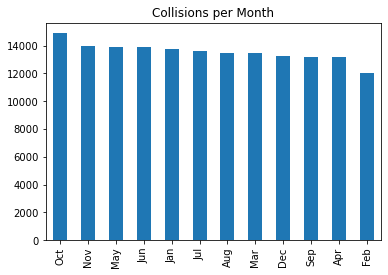

In [18]:
display(df["JURISDICTION"].value_counts())

display(df["TARGET ZERO Reportable Indicator"].value_counts())

display(df["TZ Alcohol Impaired Involved Person Indicator"].value_counts())

df["MONTH"].value_counts().plot(kind="bar", title="Collisions per Month");

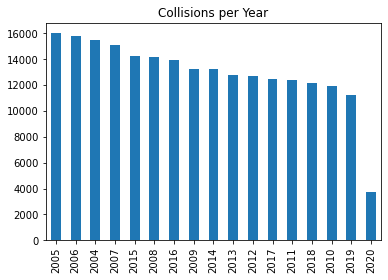

In [19]:
# display(df["YEAR"].isna().sum()) # the 58221 rows without WSDOT data have no YEAR
# df.fillna(value={"YEAR": pd.Series(pd.DatetimeIndex(df["INCDATE"]).year),
#                  "MONTH": pd.Series(pd.DatetimeIndex(df["INCDATE"]).month_name)}, inplace=True)
df["year"] = pd.DatetimeIndex(df["INCDATE"]).year
df["month"] = pd.DatetimeIndex(df["INCDATE"]).month_name

df["year"].value_counts().plot(kind="bar", title="Collisions per Year");

In [30]:
yrtable = df["YEAR"].value_counts()
print(yrtable.to_markdown(tablefmt="grid"))


+------+--------+
|      |   YEAR |
+======+========+
| 2005 |  13555 |
+------+--------+
| 2006 |  13460 |
+------+--------+
| 2007 |  12619 |
+------+--------+
| 2008 |  11817 |
+------+--------+
| 2015 |  10977 |
+------+--------+
| 2009 |  10875 |
+------+--------+
| 2014 |  10538 |
+------+--------+
| 2010 |  10363 |
+------+--------+
| 2011 |  10230 |
+------+--------+
| 2016 |  10058 |
+------+--------+
| 2017 |   9653 |
+------+--------+
| 2012 |   9527 |
+------+--------+
| 2013 |   9276 |
+------+--------+
| 2018 |   9082 |
+------+--------+
| 2019 |   8007 |
+------+--------+
| 2020 |   2389 |
+------+--------+


In [39]:
df = df[pd.DatetimeIndex(df["INCDATE"]).year != 2003]
df.drop(columns=["year", "month"], inplace=True)
print(df.shape)

save_path = "/Users/erinorbits/OneDrive/Documents/Data_Sets/seattle_collisions_merged_from_sdot_wsdot_080720.csv.zip"
df.to_csv(save_path, index=False, encoding="UTF-8", compression="zip")

(220646, 181)


In [21]:
# change column names to lowercase
df.columns = map(str.lower, df.columns)

,percent_na,total_unique
JURISDICTION,0.0,4
COUNTY,0.0,1
CITY,8.2,39
REPORT NUMBER,0.0,579792
INDEXED PRIMARY TRAFFICWAY,0.2,20974
PRIMARY TRAFFICWAY,0.0,18571
BLOCK NUMBER,59.7,8369
MILEPOST,53.2,14674
A/B,99.7,2
INTERSECTING TRAFFICWAY,70.7,16191


In [69]:
# Ignore - just looking at different results based on the initial filtering, 
# e.g., some of the SDOT data is listed with cities other than Seattle in WSDOT data

display(df.groupby(["YEAR", "MONTH"])["OBJECTID"].size().to_frame("count").reset_index().sort_values(by=["YEAR"], ascending=False).head(10))
# 2020	Jun	204
# 2020	Jul	33

# but the previous merge with the smaller WSDOT data set yielded:
# 2020  Jun    375
# 2020  Jul     69

display(df[df["YEAR"] == 2020]["MONTH"].value_counts())

# original SDOT data
# 6    418
# 7    207
print("\nSDOT data")
df_sdot["INCDATE"] = df_sdot["INCDATE"].astype("datetime64")
df_sdot["MONTH"] =  pd.DatetimeIndex(df_sdot["INCDATE"]).month
df_sdot["YEAR"] =  pd.DatetimeIndex(df_sdot["INCDATE"]).year
display(df_sdot[df_sdot["YEAR"] == 2020]["MONTH"].value_counts())

# original WSDOT data from all of King Co
# Jun    1284
# Jul     425
print("\nWSDOT data")
display(df_wsdot[df_wsdot["YEAR"] == 2020]["MONTH"].value_counts())

# df.groupby(["CITY"])["CITY"].size().to_frame('count').reset_index()
df[df["CITY"] != "Seattle"].shape # 206 rows encoded with a city other than Seattle

df_seattle = df_wsdot[df_wsdot["CITY"] == "Seattle"]
print(df_seattle.shape)
display(df_seattle.tail(3))

df_2020 = df_seattle[df_seattle["YEAR"] == 2020]
df_2020["MONTH"].value_counts()

,YEAR,MONTH,count
186,2020,May,274
185,2020,Mar,406
184,2020,Jun,204
183,2020,Jul,33
182,2020,Jan,680
181,2020,Feb,546
180,2020,Apr,246
173,2019,Jul,713
168,2019,Apr,623
169,2019,Aug,681


Jan    680
Feb    546
Mar    406
May    274
Apr    246
Jun    204
Jul     33
Name: MONTH, dtype: int64


SDOT data


1    893
2    839
3    554
6    418
5    413
4    394
7    207
Name: MONTH, dtype: int64


WSDOT data


Jan    3011
Feb    2583
Mar    1704
May    1376
Jun    1284
Apr     995
Jul     425
Name: MONTH, dtype: int64

(206, 295)